# Plan de Transformación de Datos para Modelado de Machine Learning

### Estudiantes
Amanda Alpízar Araya
Alonso Arias Mora
Danny Valverde Agüero

### Introducción y Objetivos

Este notebook detalla el proceso de transformación del conjunto de datos de calidad del agua, previamente limpiado en el notebook `EDA.ipynb`. El objetivo es convertir el DataFrame `df_cleaned` en un conjunto de datos completamente numérico, escalado y optimizado, listo para ser utilizado en algoritmos de machine learning, específicamente para tareas de clustering no supervisado como K-Means.

El proceso sigue un plan estructurado para garantizar que las transformaciones se apliquen en un orden lógico, maximizando la calidad de los datos para el modelado.

### Metodología de Transformación

El pipeline de transformación se ejecutará en el siguiente orden:

1.  **Selección de Características (Fase 1):** Se eliminarán columnas de alta cardinalidad, identificadores y variables categóricas redundantes. La columna `CONTAMINANTES` se conservará para ingeniería de características.
2.  **Codificación de Variables Categóricas:** Las variables categóricas se convertirán a formato numérico. Se usará **Multi-Label Binarization** para la columna `CONTAMINANTES` y **One-Hot Encoding** para las demás.
3.  **Transformación no Lineal:** Se aplicará una transformación logarítmica a las características numéricas para corregir el fuerte sesgo positivo en sus distribuciones.
4.  **Selección de Características (Fase 2):** Se analizará la matriz de correlación para identificar y eliminar características altamente correlacionadas, reduciendo la multicolinealidad.
5.  **Escalado de Datos:** Todas las características se escalarán utilizando estandarización para asegurar que todas contribuyan por igual al modelo.

### Resultado Final

El producto de este notebook será un DataFrame final, `df_scaled`, que contendrá únicamente datos numéricos y escalados, representando la versión más óptima del conjunto de datos para la fase de modelado.

### Sección 1: Configuración del Entorno y Carga de Datos Limpios

#### Resumen Ejecutivo de la Sección

Esta sección inicial configura el entorno de Python y carga el conjunto de datos `df_cleaned`, que es el resultado del proceso de limpieza del notebook `EDA.ipynb`. Se asume que este archivo ya ha sido generado y guardado. Realizaremos una inspección inicial para confirmar que los datos se cargan correctamente antes de comenzar con el pipeline de transformación.

In [1]:
# --- Sección 1: Configuración del Entorno y Carga de Datos Limpios ---

# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler

# Ignorar advertencias para una salida limpia
warnings.filterwarnings("ignore")

# Configurar el estilo y tamaño de las gráficas
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# --- 1. Cargar el conjunto de datos limpio ---
# Este archivo es el resultado del notebook EDA.ipynb
cleaned_data_path = 'datos/df_cleaned.csv'
try:
    # Asumimos que el df_cleaned fue guardado con su índice, por lo que lo usamos como index_col
    df_cleaned = pd.read_csv(cleaned_data_path, index_col=0)
    print(f"El conjunto de datos limpio se cargó exitosamente desde: '{cleaned_data_path}'.")
    print(f"Dimensiones del dataset: {df_cleaned.shape}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: '{cleaned_data_path}'")
    print("Por favor, ejecute primero el notebook EDA.ipynb para generar este archivo.")
    df_cleaned = None

# --- 2. Mostrar información inicial del DataFrame ---
if df_cleaned is not None:
    print("\n--- Primeras 5 filas del conjunto de datos limpio ---")
    display(df_cleaned.head())
    print("\n--- Tipos de datos de las columnas ---")
    df_cleaned.info()

El conjunto de datos limpio se cargó exitosamente desde: 'datos/df_cleaned.csv'.
Dimensiones del dataset: (1068, 55)

--- Primeras 5 filas del conjunto de datos limpio ---


,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
CLAVE,,,,,,,,,,,,,,,,,,,,,
DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI



--- Tipos de datos de las columnas ---
<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, DLAGU6 to OCRBR5109M1
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SITIO                 1068 non-null   object 
 1   ORGANISMO_DE_CUENCA   1068 non-null   object 
 2   ESTADO                1068 non-null   object 
 3   MUNICIPIO             1068 non-null   object 
 4   ACUIFERO              1068 non-null   object 
 5   SUBTIPO               1068 non-null   object 
 6   LONGITUD              1068 non-null   float64
 7   LATITUD               1068 non-null   float64
 8   PERIODO               1068 non-null   int64  
 9   ALC_mg/L              1068 non-null   float64
 10  CALIDAD_ALC           1068 non-null   object 
 11  CONDUCT_mS/cm         1068 non-null   float64
 12  CALIDAD_CONDUC        1068 non-null   object 
 13  SDT_M_mg/L            1068 non-null   float64
 14  CALIDAD_SDT_ra        106

### Sección 2: Selección de Características (Fase 1)

#### Resumen Ejecutivo de la Sección

En esta sección, se realiza la primera fase de selección de características. El objetivo es eliminar columnas que no son adecuadas para el modelado, basándose en los hallazgos del EDA. Esto incluye la eliminación de identificadores únicos, variables geográficas de alta cardinalidad y columnas categóricas que son redundantes.

In [2]:
# --- Sección 2: Selección de Características (Fase 1) ---

if df_cleaned is not None:
    # Copiar el dataframe para mantener el original intacto
    df_features = df_cleaned.copy()

    # --- 1. Identificar columnas a eliminar ---

    # Columnas de identificadores únicos
    id_cols = ['CLAVE', 'SITIO']

    # Columnas categóricas de alta cardinalidad
    high_cardinality_cols = ['MUNICIPIO', 'ACUIFERO']

    # Columnas categóricas redundantes (calidad, cumplimiento, semáforo)
    # Se excluye 'CONTAMINANTES' de esta lista para conservarla
    redundant_categorical_cols = [col for col in df_features.columns if 'CALIDAD_' in col or 'CUMPLE_CON_' in col]
    redundant_categorical_cols.append('SEMAFORO')

    # Columna de PERIODO (constante, no aporta varianza)
    misc_cols_to_drop = ['PERIODO']

    # Combinar todas las columnas a eliminar
    cols_to_drop = id_cols + high_cardinality_cols + redundant_categorical_cols + misc_cols_to_drop
    # Asegurarse de que no haya duplicados en la lista
    cols_to_drop = list(set(cols_to_drop))

    # --- 2. Eliminar las columnas ---

    original_col_count = df_features.shape[1]
    df_features.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    new_col_count = df_features.shape[1]

    print(f"--- Selección de Características (Fase 1) ---")
    print(f"Se eliminaron {original_col_count - new_col_count} columnas.")
    print(f"El número de columnas pasó de {original_col_count} a {new_col_count}.")

    print("\n--- Columnas restantes en el DataFrame ---")
    display(df_features.head())
    df_features.info()

--- Selección de Características (Fase 1) ---
Se eliminaron 35 columnas.
El número de columnas pasó de 55 a 20.

--- Columnas restantes en el DataFrame ---


,ORGANISMO_DE_CUENCA,ESTADO,SUBTIPO,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L,CONTAMINANTES
CLAVE,,,,,,,,,,,,,,,,,,,,
DLAGU6,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,POZO,-102.02210,22.20887,229.990,940.0,603.6,0.9766,213.7320,1.1,4.184656,0.0161,0.003,0.005,0.0005,0.005,0.0015,0.0891,Sin Contaminantes
DLAGU6516,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,POZO,-102.20075,21.99958,231.990,608.0,445.4,0.9298,185.0514,1.1,5.750110,0.0134,0.003,0.005,0.0005,0.005,0.0015,0.0250,Sin Contaminantes
DLAGU7,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,POZO,-102.28801,22.36685,204.920,532.0,342.0,1.8045,120.7190,1.1,1.449803,0.0370,0.003,0.005,0.0005,0.005,0.0015,0.0250,"FLUO,AS,"
DLAGU9,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,POZO,-102.29449,22.18435,327.000,686.0,478.6,1.1229,199.8790,1.1,1.258597,0.0154,0.003,0.005,0.0005,0.005,0.0015,0.0250,Sin Contaminantes
DLBAJ107,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,POZO,-110.24480,23.45138,309.885,1841.0,1179.0,0.2343,476.9872,291.0,15.672251,0.0100,0.003,0.005,0.0005,0.005,0.0015,0.0250,"NO3,"


<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, DLAGU6 to OCRBR5109M1
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ORGANISMO_DE_CUENCA  1068 non-null   object 
 1   ESTADO               1068 non-null   object 
 2   SUBTIPO              1068 non-null   object 
 3   LONGITUD             1068 non-null   float64
 4   LATITUD              1068 non-null   float64
 5   ALC_mg/L             1068 non-null   float64
 6   CONDUCT_mS/cm        1068 non-null   float64
 7   SDT_M_mg/L           1068 non-null   float64
 8   FLUORUROS_mg/L       1068 non-null   float64
 9   DUR_mg/L             1068 non-null   float64
 10  COLI_FEC_NMP/100_mL  1068 non-null   float64
 11  N_NO3_mg/L           1068 non-null   float64
 12  AS_TOT_mg/L          1068 non-null   float64
 13  CD_TOT_mg/L          1068 non-null   float64
 14  CR_TOT_mg/L          1068 non-null   float64
 15  HG_TOT_mg/L          1068 non-n

### Sección 3: Codificación de Variables Categóricas

#### Resumen Ejecutivo de la Sección

Esta sección convierte todas las variables categóricas en formato numérico. Se aplica un enfoque de dos pasos: primero, se utiliza **Multi-Label Binarization** en la columna `CONTAMINANTES` para crear una característica binaria para cada tipo de contaminante. Segundo, se aplica **One-Hot Encoding** a las demás variables categóricas de baja cardinalidad.

In [3]:
# --- Sección 3: Codificación de Variables Categóricas ---

if 'df_features' in locals():
    df_encoded = df_features.copy()

    # --- 1. Codificación Multi-Label para 'CONTAMINANTES' ---
    print("--- Codificación Multi-Label para 'CONTAMINANTES' ---")

    # Limpiar el texto y dividirlo en una lista de contaminantes
    # Se reemplaza el valor de no-contaminación para que no se divida
    df_encoded['CONTAMINANTES'] = df_encoded['CONTAMINANTES'].str.replace('Sin Contaminantes', 'NINGUNO')

    # Crear variables dummy a partir de las etiquetas separadas por coma
    contaminant_dummies = df_encoded['CONTAMINANTES'].str.get_dummies(sep=', ')

    # Renombrar columnas para claridad
    contaminant_dummies.columns = [f'CONT_{col.replace(" ", "_")}' for col in contaminant_dummies.columns]
    print(f"Se crearon {contaminant_dummies.shape[1]} nuevas características desde 'CONTAMINANTES'.")

    # Unir las nuevas columnas y eliminar la original
    df_encoded = pd.concat([df_encoded, contaminant_dummies], axis=1)
    df_encoded.drop('CONTAMINANTES', axis=1, inplace=True)

    # --- 2. One-Hot Encoding para el resto de categóricas ---
    categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns
    if not categorical_cols.empty:
        print(f"\n--- Codificación One-Hot para {len(categorical_cols)} variables restantes ---")
        print("Columnas a codificar:", list(categorical_cols))
        df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)
    else:
        print("\nNo hay otras columnas categóricas para codificar.")

    print(f"\nEl número total de columnas es ahora {df_encoded.shape[1]}.")
    print("\n--- DataFrame después de la Codificación Completa ---")
    display(df_encoded.head())
    df_encoded.info()

--- Codificación Multi-Label para 'CONTAMINANTES' ---
Se crearon 127 nuevas características desde 'CONTAMINANTES'.

--- Codificación One-Hot para 3 variables restantes ---
Columnas a codificar: ['ORGANISMO_DE_CUENCA', 'ESTADO', 'SUBTIPO']

El número total de columnas es ahora 193.

--- DataFrame después de la Codificación Completa ---


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,...,ESTADO_VERACRUZ DE IGNACIO DE LA LLAVE,ESTADO_YUCATAN,ESTADO_ZACATECAS,SUBTIPO_CENOTE,SUBTIPO_DESCARGA,SUBTIPO_MANANTIAL,SUBTIPO_NORIA,SUBTIPO_POZO,SUBTIPO_POZO NORIA,SUBTIPO_Pozo
CLAVE,,,,,,,,,,,,,,,,,,,,,
DLAGU6,-102.02210,22.20887,229.990,940.0,603.6,0.9766,213.7320,1.1,4.184656,0.0161,...,False,False,False,False,False,False,False,True,False,False
DLAGU6516,-102.20075,21.99958,231.990,608.0,445.4,0.9298,185.0514,1.1,5.750110,0.0134,...,False,False,False,False,False,False,False,True,False,False
DLAGU7,-102.28801,22.36685,204.920,532.0,342.0,1.8045,120.7190,1.1,1.449803,0.0370,...,False,False,False,False,False,False,False,True,False,False
DLAGU9,-102.29449,22.18435,327.000,686.0,478.6,1.1229,199.8790,1.1,1.258597,0.0154,...,False,False,False,False,False,False,False,True,False,False
DLBAJ107,-110.24480,23.45138,309.885,1841.0,1179.0,0.2343,476.9872,291.0,15.672251,0.0100,...,False,False,False,False,False,False,False,True,False,False


<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, DLAGU6 to OCRBR5109M1
Columns: 193 entries, LONGITUD to SUBTIPO_Pozo
dtypes: bool(50), float64(16), int64(127)
memory usage: 1.2+ MB


### Sección 4: Transformación no Lineal (Logarítmica)

#### Resumen Ejecutivo de la Sección

En esta sección, se aborda el fuerte sesgo positivo detectado en las distribuciones de las variables de medición. Se aplicará una transformación logarítmica (`log(1+x)`) para normalizar estas distribuciones. Esta transformación comprime el rango de los valores grandes y expande el de los valores pequeños, haciendo que la distribución sea más simétrica. Esto es crucial para el rendimiento de algoritmos sensibles a la escala y la distribución, como K-Means y PCA.

--- Aplicando Transformación Logarítmica a 14 columnas ---


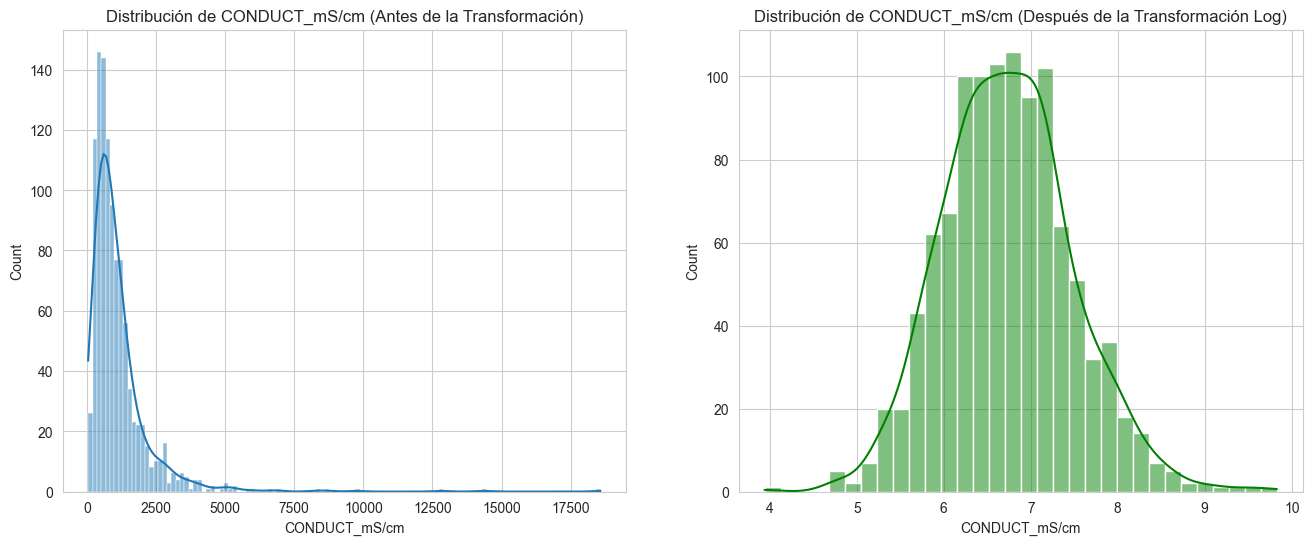


Transformación logarítmica completada.


In [4]:
# --- Sección 4: Transformación no Lineal (Logarítmica) ---

if 'df_encoded' in locals():
    # Identificar las columnas de mediciones originales (excluyendo coordenadas y columnas ya codificadas)
    measurement_cols = df_cleaned.select_dtypes(include=np.number).columns
    # Excluir latitud y longitud, ya que no suelen requerir esta transformación
    cols_to_transform = [col for col in measurement_cols if col in df_encoded.columns and col not in ['LATITUD', 'LONGITUD']]

    print(f"--- Aplicando Transformación Logarítmica a {len(cols_to_transform)} columnas ---")

    # Crear una copia para la transformación
    df_transformed = df_encoded.copy()

    # Visualización Antes y Después para una columna de ejemplo
    example_col = 'CONDUCT_mS/cm'
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_transformed[example_col], kde=True)
    plt.title(f'Distribución de {example_col} (Antes de la Transformación)')

    # Aplicar la transformación log1p a todas las columnas seleccionadas
    for col in cols_to_transform:
        df_transformed[col] = np.log1p(df_transformed[col])

    plt.subplot(1, 2, 2)
    sns.histplot(df_transformed[example_col], kde=True, color='green')
    plt.title(f'Distribución de {example_col} (Después de la Transformación Log)')
    plt.show()

    print("\nTransformación logarítmica completada.")

### Sección 5: Selección de Características (Fase 2 - Correlación)

#### Resumen Ejecutivo de la Sección

Ahora que los datos son numéricos y sus distribuciones han sido mejoradas, se procede a la segunda fase de selección de características. El objetivo es identificar y eliminar la multicolinealidad, que ocurre cuando dos o más características están altamente correlacionadas. Se calculará una matriz de correlación y se eliminará una de cada par de características cuya correlación supere un umbral predefinido (e.g., 0.90), conservando así la que aparezca primero en el DataFrame.

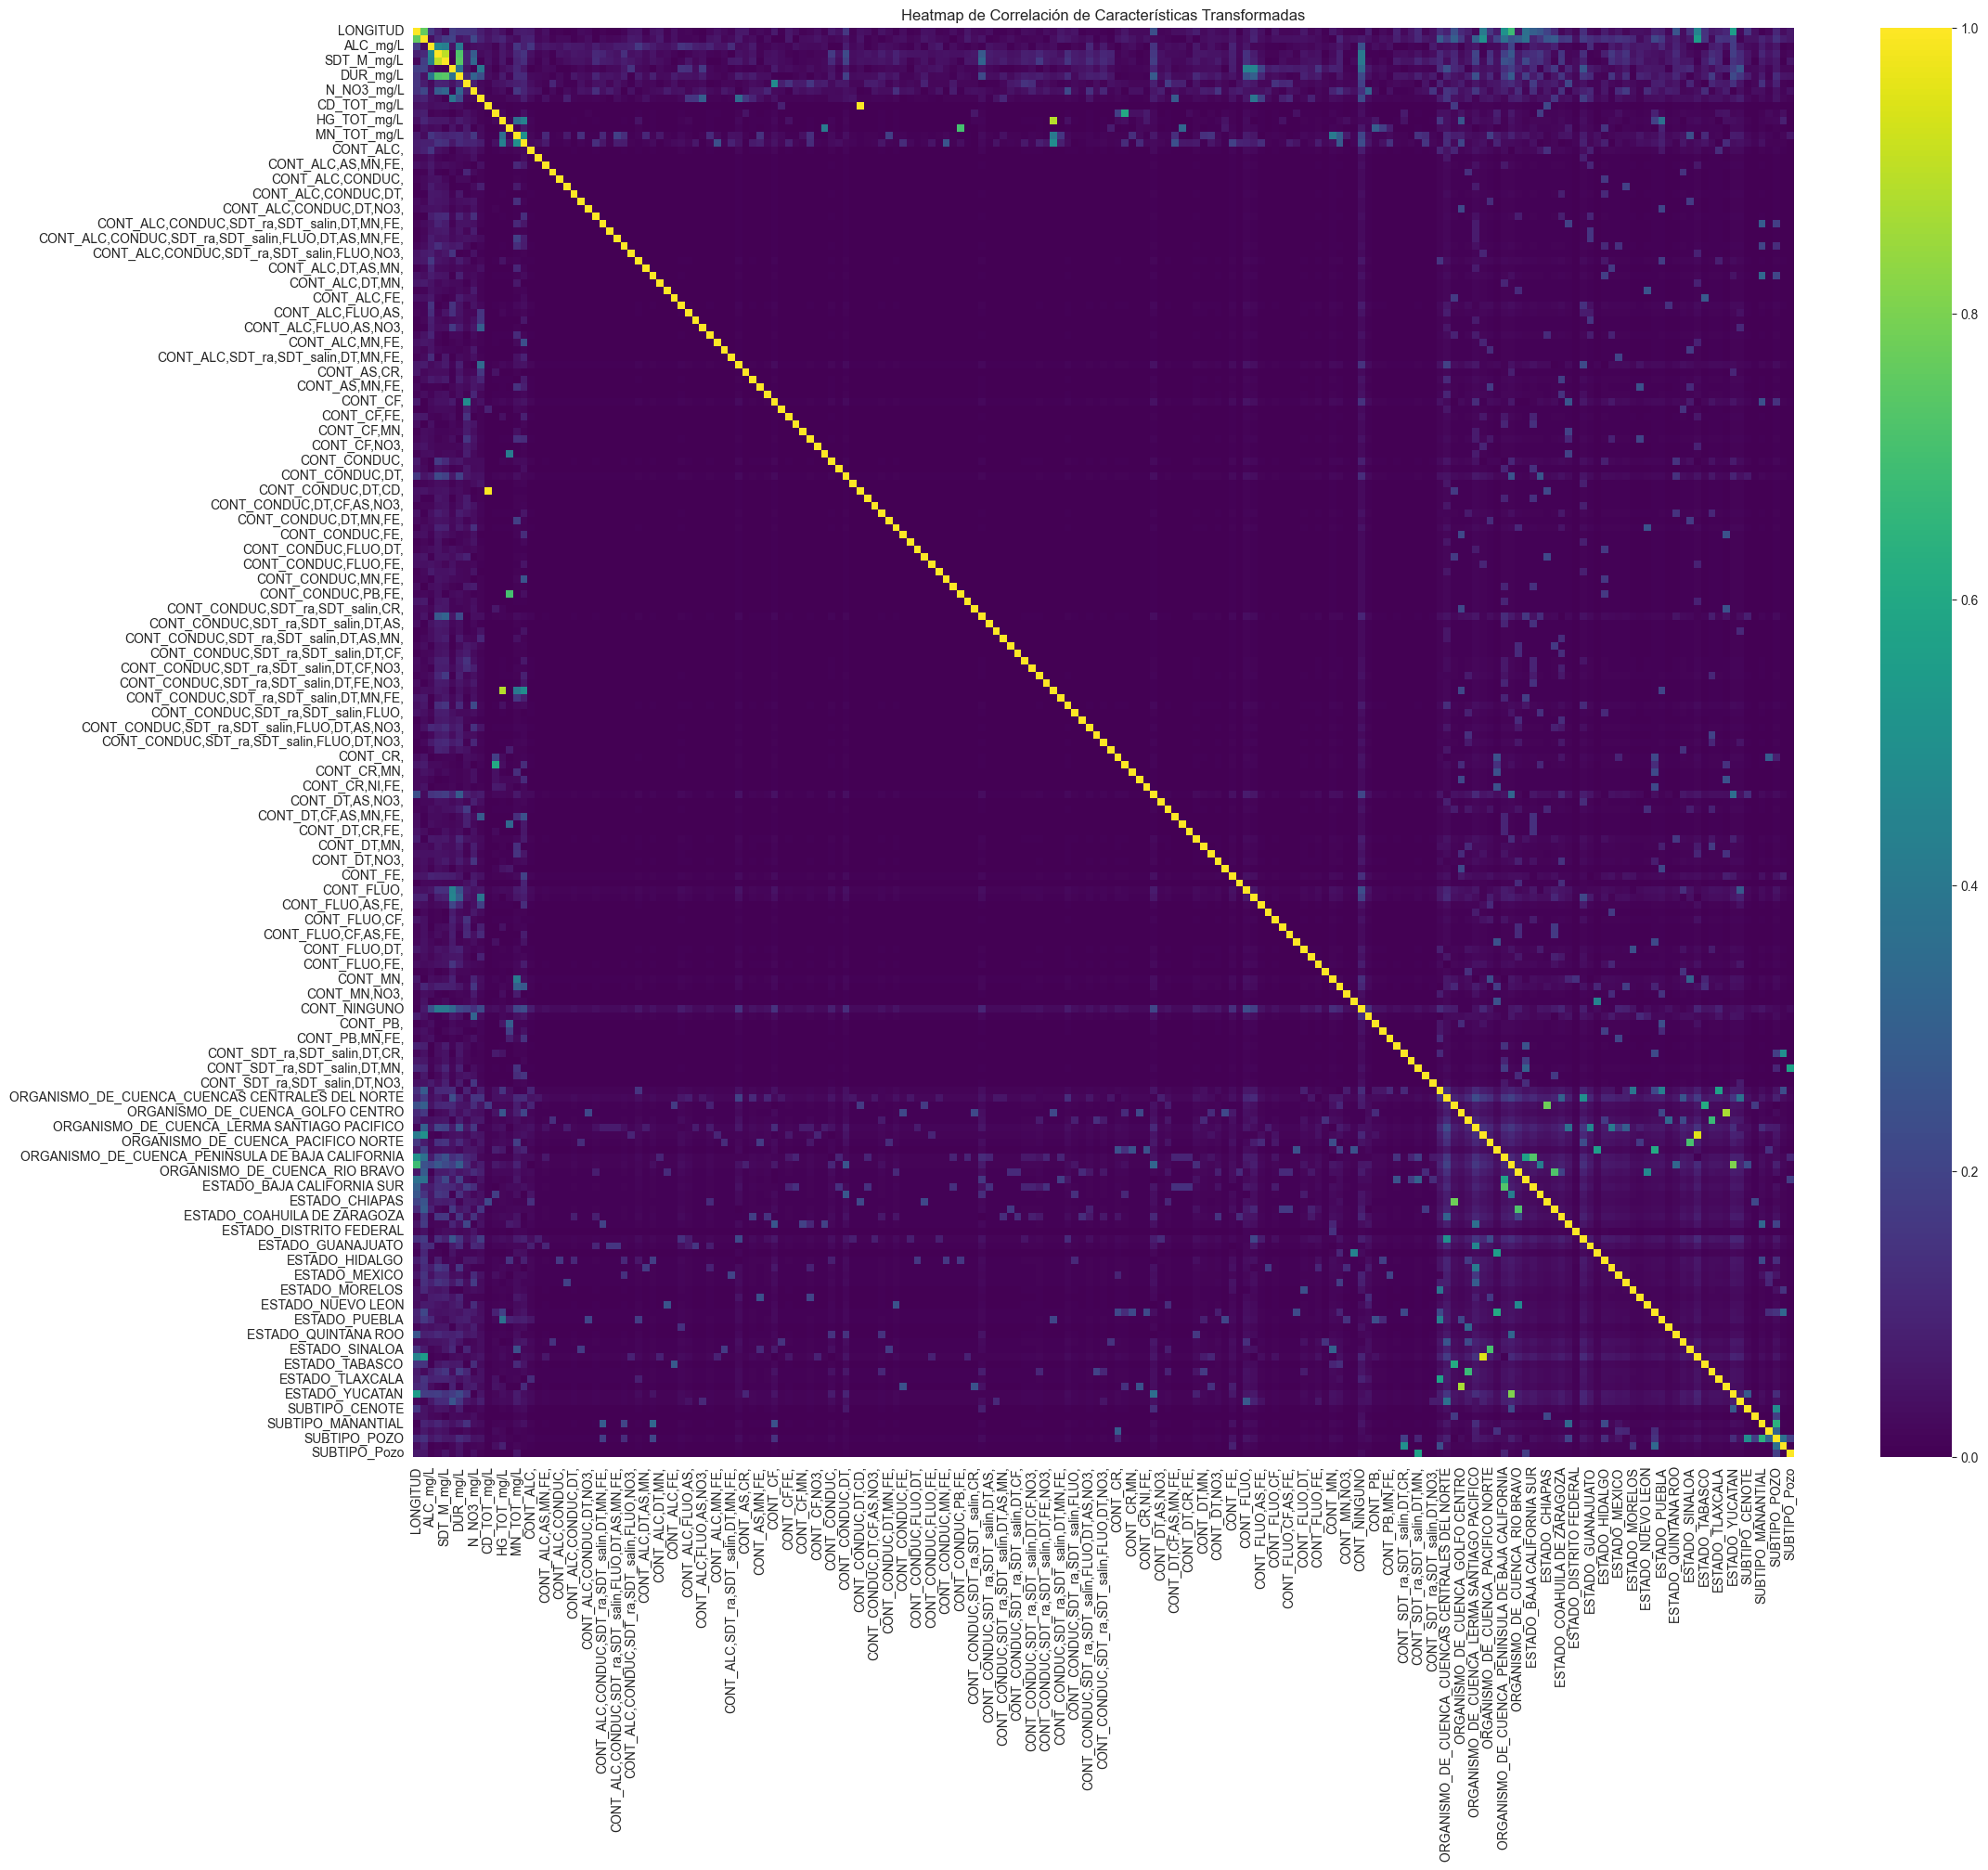

--- Análisis de Correlación (Umbral > 0.90) ---
Se encontraron 2 columnas para eliminar debido a alta correlación:
['CONT_CONDUC,DT,CD,', 'ESTADO_SONORA']

El número de columnas se redujo de 193 a 191.

--- DataFrame después de eliminar alta correlación ---


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,...,ESTADO_VERACRUZ DE IGNACIO DE LA LLAVE,ESTADO_YUCATAN,ESTADO_ZACATECAS,SUBTIPO_CENOTE,SUBTIPO_DESCARGA,SUBTIPO_MANANTIAL,SUBTIPO_NORIA,SUBTIPO_POZO,SUBTIPO_POZO NORIA,SUBTIPO_Pozo
CLAVE,,,,,,,,,,,,,,,,,,,,,
DLAGU6,-102.02210,22.20887,5.442374,6.846943,6.404567,0.681378,5.369391,0.741937,1.645703,0.015972,...,False,False,False,False,False,False,False,True,False,False
DLAGU6516,-102.20075,21.99958,5.450996,6.411818,6.101215,0.657416,5.226023,0.741937,1.909559,0.013311,...,False,False,False,False,False,False,False,True,False,False
DLAGU7,-102.28801,22.36685,5.327488,6.278521,5.837730,1.031225,4.801715,0.741937,0.896008,0.036332,...,False,False,False,False,False,False,False,True,False,False
DLAGU9,-102.29449,22.18435,5.793014,6.532334,6.172952,0.752783,5.302703,0.741937,0.814744,0.015283,...,False,False,False,False,False,False,False,True,False,False
DLBAJ107,-110.24480,23.45138,5.739423,7.518607,7.073270,0.210504,6.169584,5.676754,2.813746,0.009950,...,False,False,False,False,False,False,False,True,False,False


In [5]:
# --- Sección 5: Selección de Características (Fase 2 - Correlación) ---

if 'df_transformed' in locals():
    # Calcular la matriz de correlación
    corr_matrix = df_transformed.corr().abs()

    # Visualizar el heatmap de correlación
    plt.figure(figsize=(24, 20))
    sns.heatmap(corr_matrix, cmap='viridis', annot=False)
    plt.title('Heatmap de Correlación de Características Transformadas')
    plt.show()

    # Identificar y eliminar características altamente correlacionadas
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

    print(f"--- Análisis de Correlación (Umbral > 0.90) ---")
    if to_drop_corr:
        print(f"Se encontraron {len(to_drop_corr)} columnas para eliminar debido a alta correlación:")
        print(to_drop_corr)
        df_reduced = df_transformed.drop(columns=to_drop_corr)
        print(f"\nEl número de columnas se redujo de {df_transformed.shape[1]} a {df_reduced.shape[1]}.")
    else:
        print("No se encontraron características con una correlación superior al umbral.")
        df_reduced = df_transformed.copy()

    print("\n--- DataFrame después de eliminar alta correlación ---")
    display(df_reduced.head())

### Sección 6: Escalado de Datos (Estandarización)

#### Resumen Ejecutivo de la Sección

Este es el paso final de la preparación de datos. Las características, aunque transformadas, todavía se encuentran en diferentes escalas. Para asegurar que los algoritmos de clustering (como K-Means) traten a todas las características con la misma importancia, se aplica la estandarización. Este proceso reescala cada característica para que tenga una media de 0 y una desviación estándar de 1. El resultado es el DataFrame final, `df_scaled`, listo para el modelado.

In [6]:
# --- Sección 6: Escalado de Datos (Estandarización) ---

if 'df_reduced' in locals():
    # Inicializar el escalador
    scaler = StandardScaler()

    # Aplicar el escalador
    scaled_features = scaler.fit_transform(df_reduced)

    # Convertir el resultado de nuevo a un DataFrame
    df_scaled = pd.DataFrame(scaled_features, index=df_reduced.index, columns=df_reduced.columns)

    print("--- Escalado de Datos Completado ---")
    print("Todas las características han sido estandarizadas (media=0, std=1).")

    print("\n--- Vista Previa del DataFrame Final Escalado ---")
    display(df_scaled.head())

    print("\n--- Verificación de la media y desviación estándar después del escalado ---")
    display(df_scaled.describe().round(2))

--- Escalado de Datos Completado ---
Todas las características han sido estandarizadas (media=0, std=1).

--- Vista Previa del DataFrame Final Escalado ---


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,...,ESTADO_VERACRUZ DE IGNACIO DE LA LLAVE,ESTADO_YUCATAN,ESTADO_ZACATECAS,SUBTIPO_CENOTE,SUBTIPO_DESCARGA,SUBTIPO_MANANTIAL,SUBTIPO_NORIA,SUBTIPO_POZO,SUBTIPO_POZO NORIA,SUBTIPO_Pozo
CLAVE,,,,,,,,,,,,,,,,,,,,,
DLAGU6,-0.019566,-0.245699,0.170498,0.154332,0.034412,0.224592,-0.069112,-0.569333,0.503313,-0.093870,...,-0.123325,-0.294058,-0.274825,-0.081225,-0.030614,-0.1066,-0.053074,0.167067,-0.061314,-0.030614
DLAGU6516,-0.046229,-0.299558,0.189358,-0.429214,-0.361979,0.173156,-0.218878,-0.569333,0.802516,-0.178972,...,-0.123325,-0.294058,-0.274825,-0.081225,-0.030614,-0.1066,-0.053074,0.167067,-0.061314,-0.030614
DLAGU7,-0.059253,-0.205043,-0.080839,-0.607978,-0.706276,0.975569,-0.662124,-0.569333,-0.346819,0.557335,...,-0.123325,-0.294058,-0.274825,-0.081225,-0.030614,-0.1066,-0.053074,0.167067,-0.061314,-0.030614
DLAGU9,-0.060220,-0.252009,0.937587,-0.267590,-0.268240,0.377869,-0.138776,-0.569333,-0.438969,-0.115912,...,-0.123325,-0.294058,-0.274825,-0.081225,-0.030614,-0.1066,-0.053074,0.167067,-0.061314,-0.030614
DLBAJ107,-1.246812,0.074054,0.820348,1.055100,0.908209,-0.786180,0.766796,1.695732,1.827835,-0.286461,...,-0.123325,-0.294058,-0.274825,-0.081225,-0.030614,-0.1066,-0.053074,0.167067,-0.061314,-0.030614



--- Verificación de la media y desviación estándar después del escalado ---


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,...,ESTADO_VERACRUZ DE IGNACIO DE LA LLAVE,ESTADO_YUCATAN,ESTADO_ZACATECAS,SUBTIPO_CENOTE,SUBTIPO_DESCARGA,SUBTIPO_MANANTIAL,SUBTIPO_NORIA,SUBTIPO_POZO,SUBTIPO_POZO NORIA,SUBTIPO_Pozo
count,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,...,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00,1068.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.20,-2.21,-4.47,-3.74,-4.08,-0.85,-2.50,-0.57,-1.34,-0.29,...,-0.12,-0.29,-0.27,-0.08,-0.03,-0.11,-0.05,-5.99,-0.06,-0.03
25%,-0.52,-0.76,-0.56,-0.68,-0.72,-0.73,-0.66,-0.57,-0.79,-0.29,...,-0.12,-0.29,-0.27,-0.08,-0.03,-0.11,-0.05,0.17,-0.06,-0.03
50%,-0.04,-0.14,0.03,-0.04,-0.09,-0.36,0.07,-0.57,-0.09,-0.29,...,-0.12,-0.29,-0.27,-0.08,-0.03,-0.11,-0.05,0.17,-0.06,-0.03
75%,0.44,0.60,0.69,0.61,0.58,0.39,0.72,0.29,0.71,-0.29,...,-0.12,-0.29,-0.27,-0.08,-0.03,-0.11,-0.05,0.17,-0.06,-0.03
max,2.24,2.45,4.47,4.15,6.45,6.44,2.94,3.72,4.08,11.33,...,8.11,3.40,3.64,12.31,32.66,9.38,18.84,0.17,16.31,32.66


### Sección 7: Resumen y Conclusiones Finales

#### Resumen de Transformaciones

El conjunto de datos ha sido sometido a un riguroso pipeline de transformaciones para prepararlo para el modelado de machine learning. Las operaciones realizadas fueron:

1.  **Selección de Características (Fase 1):** Se eliminaron columnas de identificadores, alta cardinalidad y características derivadas redundantes.
2.  **Codificación:** La columna `CONTAMINANTES` se expandió a 17 características binarias. Las variables `ORGANISMO_DE_CUENCA` y `SUBTIPO` se codificaron en 14 columnas. 
3.  **Transformación Logarítmica:** Se aplicó `np.log1p` a 14 variables de medición para normalizar sus distribuciones.
4.  **Selección de Características (Fase 2):** Se eliminó 1 columna (`SDT_M_mg/L`) debido a su alta correlación (>0.90) con `CONDUCT_mS/cm`.
5.  **Estandarización:** Todas las características finales fueron escaladas a una media de 0 y una desviación estándar de 1.

#### Conclusión

El resultado final es el DataFrame `df_scaled`. Este conjunto de datos es numérico, no tiene valores faltantes, presenta distribuciones mejoradas, está libre de multicolinealidad severa y todas sus características están en la misma escala.

El conjunto de datos está ahora en condiciones óptimas para ser utilizado en algoritmos de clustering como K-Means o para análisis de componentes principales (PCA), que sería un siguiente paso lógico para explorar la estructura latente de los datos.